In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [79]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [5]:

pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 10000)

In [13]:
target = 10001
data = pd.read_csv("../data/"+str(target)+"_feature.csv")
data["date"] = pd.to_datetime(data["date"])
data.head()

,date,10000lag1,10001lag1,10002lag1,10000lag2,10001lag2,10002lag2,10000lag3,10001lag3,10002lag3,10000lag4,10001lag4,10002lag4,10000lag5,10001lag5,10002lag5,y
0,2017-04-06,-0.81,-0.83,-0.71,-0.99,-0.91,-0.67,-0.98,-0.81,-0.50,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29,-1.07
1,2017-04-07,-0.99,-0.91,-0.67,-0.98,-0.81,-0.50,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46,-0.56
2,2017-04-08,-0.98,-0.81,-0.50,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46,-1.29,-0.98,-0.56,-0.98
3,2017-04-09,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46,-1.29,-0.98,-0.56,-0.98,-0.82,-0.62,-0.82
4,2017-04-10,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46,-1.29,-0.98,-0.56,-0.98,-0.82,-0.62,-1.63,-1.45,-1.06,-1.45


In [87]:
data.tail()

,date,10000lag1,10001lag1,10002lag1,10000lag2,10001lag2,10002lag2,10000lag3,10001lag3,10002lag3,10000lag4,10001lag4,10002lag4,10000lag5,10001lag5,10002lag5,y
360,2018-04-01,-0.305455,2.065455,4.527273,-0.402727,1.952727,4.423636,-0.50,1.84,4.32,-6.98,-3.12,1.21,NaN,NaN,NaN,NaN
361,2018-04-02,-0.402727,1.952727,4.423636,-0.500000,1.840000,4.320000,-6.98,-3.12,1.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,2018-04-03,-0.500000,1.840000,4.320000,-6.980000,-3.120000,1.210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,2018-04-04,-6.980000,-3.120000,1.210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,2018-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
train = data.loc[data["date"] <= pd.to_datetime("2017/11/30"),:] #2017/4/6~11/31
valid = data.loc[(data["date"] > pd.to_datetime("2017/11/30")) & (data["date"] <= pd.to_datetime("2017/12/31")),:] #2017/12/1~12/31
test = data.loc[(data["date"] > pd.to_datetime("2017/12/31")) & (data["date"] < pd.to_datetime("2018/4/1")),:] # 2018/1/1~3/31

In [89]:
train.columns

Index(['date', '10000lag1', '10001lag1', '10002lag1', '10000lag2', '10001lag2',
       '10002lag2', '10000lag3', '10001lag3', '10002lag3', '10000lag4',
       '10001lag4', '10002lag4', '10000lag5', '10001lag5', '10002lag5', 'y'],
      dtype='object')

In [90]:
feature_name = ['10000lag1', '10001lag1', '10002lag1', '10000lag2', '10001lag2',
       '10002lag2', '10000lag3', '10001lag3', '10002lag3', '10000lag4',
       '10001lag4', '10002lag4', '10000lag5', '10001lag5', '10002lag5']
train_X = train[feature_name]
print(train_X.shape)
train_X.head()

(239, 15)


,10000lag1,10001lag1,10002lag1,10000lag2,10001lag2,10002lag2,10000lag3,10001lag3,10002lag3,10000lag4,10001lag4,10002lag4,10000lag5,10001lag5,10002lag5
0,-0.81,-0.83,-0.71,-0.99,-0.91,-0.67,-0.98,-0.81,-0.50,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29
1,-0.99,-0.91,-0.67,-0.98,-0.81,-0.50,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46
2,-0.98,-0.81,-0.50,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46,-1.29,-0.98,-0.56
3,-0.97,-0.71,-0.33,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46,-1.29,-0.98,-0.56,-0.98,-0.82,-0.62
4,-1.48,-1.07,-0.29,-0.66,-0.56,-0.46,-1.29,-0.98,-0.56,-0.98,-0.82,-0.62,-1.63,-1.45,-1.06


In [91]:
train_y = train["y"]
train_y.head()

0   -1.07
1   -0.56
2   -0.98
3   -0.82
4   -1.45
Name: y, dtype: float64

In [92]:
test_X = test[feature_name]
test_y = test["y"]

print(test_X.shape)
test_y

(90, 15)


270   -3.070000
271    1.890000
272   -2.920000
273   -2.900000
274    2.900000
275    4.970000
276    2.890000
277    4.620000
278   -2.020000
279    2.680000
280    2.920000
281   -2.950000
282    3.110000
283   -2.630000
284   -2.490000
285    3.710000
286    2.550000
287    4.200000
288    3.748462
289    3.296923
290    2.845385
291    2.393846
292    1.942308
293    1.490769
294    1.039231
295    0.587692
296    0.136154
297   -0.315385
298   -0.766923
299   -1.218462
300   -1.670000
301   -1.642174
302   -1.614348
303   -1.586522
304   -1.558696
305   -1.530870
306   -1.503043
307   -1.475217
308   -1.447391
309   -1.419565
310   -1.391739
311   -1.363913
312   -1.336087
313   -1.308261
314   -1.280435
315   -1.252609
316   -1.224783
317   -1.196957
318   -1.169130
319   -1.141304
320   -1.113478
321   -1.085652
322   -1.057826
323   -1.030000
324   -2.270000
325   -1.800000
326   -0.425000
327    0.950000
328    2.325000
329    3.700000
330    2.875000
331    2.050000
332    3

In [93]:
valid_X = valid[feature_name]
valid_y = valid["y"]
print(valid_X.shape)

(31, 15)


# 学習

In [55]:

dtrain = xgb.DMatrix(train_X, label=train_y, feature_names=feature_name)
dvalid = xgb.DMatrix(valid_X, label=valid_y, feature_names = feature_name)
watchlist = [(dtrain,"train"),(dvalid,"valid")]

## CV

In [71]:
#gridsearch 時間かかるのでパラメータ調整したいときのみ実行

xgb_pars = []

MCWlist = [10, 30,50]
ETAlist =  [0.05,0.2,0.3]
CSlist = [0.3,0.7]
MDlist =  [6,8,10]
SSlist = [0.5,0.9]
LAMBDAlist = [0.5,0.7]

for MCW in MCWlist:

    for ETA in ETAlist:

        for CS in CSlist:

            for MD in MDlist:

                for SS in SSlist:

                    for LAMBDA in LAMBDAlist:

                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 

                                         'colsample_bytree': CS, 'max_depth': MD,

                                         'subsample': SS, 'lambda': LAMBDA, 

                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',

                                         'silent': 1, 'objective': 'reg:linear'})
patterns = len(MCWlist)*len(ETAlist)*len(CSlist)*len(MDlist)*len(SSlist)*len(LAMBDAlist)

print(patterns)

216


In [72]:
scores = []
for i in range(len(xgb_pars)):
    
    model = xgb.train(xgb_pars[i], dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=False)
    scores.append(model.best_score)
    print(i/patterns)


print("____________________________________")
print("best score")
print(pd.Series(scores).min())
print("best param")
print(xgb_pars[pd.Series(scores).argmin()])

0.0
0.004629629629629629
0.009259259259259259
0.013888888888888888
0.018518518518518517
0.023148148148148147
0.027777777777777776
0.032407407407407406
0.037037037037037035
0.041666666666666664
0.046296296296296294
0.05092592592592592
0.05555555555555555
0.06018518518518518
0.06481481481481481
0.06944444444444445
0.07407407407407407
0.0787037037037037
0.08333333333333333
0.08796296296296297
0.09259259259259259
0.09722222222222222
0.10185185185185185
0.10648148148148148
0.1111111111111111
0.11574074074074074
0.12037037037037036
0.125
0.12962962962962962
0.13425925925925927
0.1388888888888889
0.14351851851851852
0.14814814814814814
0.1527777777777778
0.1574074074074074
0.16203703703703703
0.16666666666666666
0.1712962962962963
0.17592592592592593
0.18055555555555555
0.18518518518518517
0.18981481481481483
0.19444444444444445
0.19907407407407407
0.2037037037037037
0.20833333333333334
0.21296296296296297
0.2175925925925926
0.2222222222222222
0.22685185185185186
0.23148148148148148
0.2361111

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


In [75]:

xgb_pars = {'min_child_weight': 10, 'eta': 0.2, 'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.9, 'lambda': 0.5, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [76]:
model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:2.11596	valid-rmse:3.17727
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.256869	valid-rmse:3.62274
[20]	train-rmse:0.061708	valid-rmse:3.67033
[30]	train-rmse:0.043361	valid-rmse:3.66922
[40]	train-rmse:0.03437	valid-rmse:3.65497
[50]	train-rmse:0.027602	valid-rmse:3.64872
Stopping. Best iteration:
[0]	train-rmse:2.11596	valid-rmse:3.17727



# 予測

In [101]:
#trainとvalidデータの予測
tv_X = pd.concat((train_X,valid_X))
tv_y = pd.concat((train_y,valid_y))
print(tv_X.shape)
dfeature = xgb.DMatrix(tv_X.values, label=tv_y.values, feature_names=feature_name)
train_predict = model.predict(dfeature)
print(train_predict.shape)
train_predict

(270, 15)
(270,)


array([-1.0760534 , -0.63286245, -0.97800016, -0.7914939 , -1.4274565 ,
       -1.0795029 , -0.6509235 , -1.1375959 , -1.1184069 , -1.2327479 ,
       -1.3632487 , -0.99732614, -1.1443485 , -1.0648583 , -0.9761113 ,
       -1.1029315 , -1.3145007 , -1.1674199 , -1.0742319 , -0.7476928 ,
       -0.786263  , -1.5564842 , -1.443738  , -1.0951076 , -1.1884241 ,
       -1.1553868 , -1.4518133 , -1.4799066 , -1.3859832 , -1.2530252 ,
       -1.085091  , -0.8342538 , -1.2948502 , -1.7014451 , -1.2311301 ,
       -1.3447281 , -0.7048031 , -0.89881825, -1.0946776 , -1.2847161 ,
       -1.4900861 , -1.028785  , -2.9585695 , -4.914277  , -1.1003487 ,
       -1.593252  , -1.3939308 , -1.5724235 , -1.4891204 , -0.8273723 ,
       -1.4504019 , -1.2585938 , -1.6337552 , -1.5507238 , -5.1631117 ,
       -0.8665432 , -1.6094115 , -1.2621684 , -1.2821908 , -1.3706816 ,
       -4.373842  , -1.4828274 , -1.2803471 , -1.6720219 , -2.6947715 ,
       -3.7181644 , -4.818829  , -1.0145133 , -1.0836253 , -1.22

In [97]:
#testデータの予測
dtest = xgb.DMatrix(test_X.values, label=test_y.values, feature_names=feature_name)
test_predict = model.predict(dtest)
print(test_predict.shape)
test_predict

(90,)


array([-2.969381  , -0.8137592 , -2.8495708 , -2.8963044 , -0.83264565,
       -0.75786066, -0.7925619 , -0.75015926, -1.9817688 , -0.77795315,
       -0.719126  , -2.8461962 , -0.8241725 , -2.52108   , -2.567643  ,
       -0.83264565, -0.75786066, -0.7925619 , -0.75015926, -0.7067143 ,
       -0.7067143 , -0.7067143 , -0.7067143 , -0.70079744, -0.690428  ,
       -0.6762495 , -0.6568357 , -0.73151314, -0.7452395 , -1.2143793 ,
       -1.6722081 , -1.658284  , -1.6234789 , -1.5948937 , -1.615459  ,
       -1.5926552 , -1.5462248 , -1.5427554 , -1.4698502 , -1.4237727 ,
       -1.4302138 , -1.4277253 , -1.4128062 , -1.3540714 , -1.3340547 ,
       -1.3068672 , -1.2799313 , -1.3057735 , -1.2972018 , -1.2782329 ,
       -1.2153012 , -1.2133967 , -1.2126507 , -1.1527957 , -2.2299068 ,
       -1.891063  , -0.89761066, -0.75329757, -0.79757655, -0.7705101 ,
       -0.7255981 , -0.6866189 , -0.69634485, -0.70079744, -4.108696  ,
       -0.77034676, -0.719126  , -3.785214  , -3.2198687 , -2.82

In [102]:
tv_rmse = np.sqrt(mean_squared_error(tv_y, train_predict))
print("tvデータの予想のRMSE =",tv_rmse)
te_rmse = np.sqrt(mean_squared_error(test_y, test_predict))
print("testデータの予想のRMSE =",te_rmse)

tvデータの予想のRMSE = 1.236615537758533
testデータの予想のRMSE = 2.533532387621026


Text(0.5,0.98,'estimation_of_kilo10001')

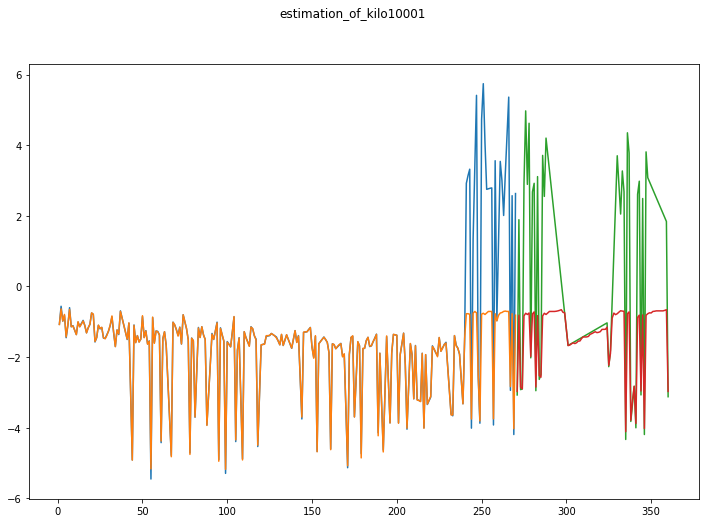

In [106]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.plot(list(range(1,tv_X.shape[0]+1)),tv_y)
ax1.plot(list(range(1,tv_X.shape[0]+1)),train_predict)

ax1.plot(list(range(tv_X.shape[0]+1,tv_X.shape[0]+test_X.shape[0]+1)), test_y.values)
ax1.plot(list(range(tv_X.shape[0]+1,tv_X.shape[0]+test_X.shape[0]+1)), test_predict)

fig.suptitle("estimation_of_kilo10001")
